In [12]:
import re
import os
import tqdm
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from collections import Counter
import gensim
import nltk
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from gensim.scripts.glove2word2vec import glove2word2vec

from joblib import dump
from joblib import load

In [3]:
data_path = "data/html/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:
            
        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )
                
        code2convos[file_code] = convo_texts

100%|██████████| 127/127 [00:24<00:00,  5.28it/s]


In [4]:
# let's see one of the conversations
pprint(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"][0])

{'role': 'user',
 'text': 'Load a CSV file into a Pandas in Python. The file is named '
         "'cs412_hw1_dataset.csv' and contains columns like 'Species', "
         "'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', "
         "'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and "
         "'Health Metrics'. \n"}


#### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

#### Prompt Matching
> We want to match the prompts with the questions in the Homework Let's
> do it with a simple term frequency vectorizing method. For each prompt,
> we will come with a vector that represents it. We will do the same
> thing with each of the homework questions. Then, we will calculate the
> vectors distanance to do the matching

In [5]:
prompts = []
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"])
            user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts    

In [6]:
prompts[0]

"Load a CSV file into a Pandas in Python. The file is named 'cs412_hw1_dataset.csv' and contains columns like 'Species', 'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', 'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and 'Health Metrics'. \n"

In [7]:
questions = [
    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset (5 pts)
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing (15 pts)
Understanding the Dataset: (5 pts)
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: (10 pts)

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
#####################
"""Set X & y, split data (5 pts)

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations (10 pts)

* Correlations of features with health (4 points)
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection (3 points)
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features (3 points)
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters (20 pts)
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen (15 pts)
- Re-train model with the hyperparameters you have chosen in part 5). (10 pts)
- Plot the tree you have trained. (5 pts)
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set (20 pts)
- Predict the labels of testing data using the tree you have trained in step 6. (10 pts)
- Report the classification accuracy. (2 pts)
- Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split (10 pts)""",
#####################
]

In [8]:
"""
glove_input_file = 'glove/glove.6B.100d.txt'
word2vec_output_file = 'glove/glove.6B.100d.word2vec.txt'
glove2word2vec(glove_input_file, word2vec_output_file)

glove_input_file = 'glove/glove.6B.50d.txt'
word2vec_output_file = 'glove/glove.6B.50d.word2vec.txt'
glove2word2vec(glove_input_file, word2vec_output_file)

glove_input_file = 'glove/glove.6B.200d.txt'
word2vec_output_file = 'glove/glove.6B.200d.word2vec.txt'
glove2word2vec(glove_input_file, word2vec_output_file)
"""

"\nglove_input_file = 'glove/glove.6B.100d.txt'\nword2vec_output_file = 'glove/glove.6B.100d.word2vec.txt'\nglove2word2vec(glove_input_file, word2vec_output_file)\n\nglove_input_file = 'glove/glove.6B.50d.txt'\nword2vec_output_file = 'glove/glove.6B.50d.word2vec.txt'\nglove2word2vec(glove_input_file, word2vec_output_file)\n\nglove_input_file = 'glove/glove.6B.200d.txt'\nword2vec_output_file = 'glove/glove.6B.200d.word2vec.txt'\nglove2word2vec(glove_input_file, word2vec_output_file)\n"

In [14]:
glove_model = load('joblib_models/glove_model_50d.joblib')
def preprocess_and_tokenize(text):
    words = word_tokenize(text.lower())
    return [word for word in words if word.isalpha()]


In [15]:
def vectorize_prompts(prompts, model):
    vectorized = []
    for prompt in prompts:
        words = preprocess_and_tokenize(prompt)
        word_vectors = [model[word] for word in words if word in model.key_to_index]

        if len(word_vectors) == 0:
            vectorized.append(np.zeros(model.vector_size))  
        else:
            vectorized.append(np.mean(word_vectors, axis=0)) 

    return pd.DataFrame(vectorized)

code2prompts_glove = dict()

for code, user_prompts in code2prompts.items():
    if len(user_prompts) > 0:
        vectorized_df = vectorize_prompts(user_prompts, glove_model)
        code2prompts_glove[code] = vectorized_df
    else:
        print(f"{code}.html has no prompts")
        
print(code2prompts_glove["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].shape)

139235c7-736c-4237-92f0-92e8c116832c.html has no prompts
668ad17e-0240-49f7-b5a7-d22e502554c6.html has no prompts
b0640e51-6879-40cb-a4f5-329f952ef99d.html has no prompts
da6b70d5-29f6-491a-ad46-037c77067128.html has no prompts
(86, 50)


In [16]:
code2prompts_glove["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.225301,-0.015033,0.189490,-0.215398,0.354149,-0.176264,-0.285527,-0.197234,-0.147202,0.083706,...,0.234391,-0.130906,0.009280,0.500356,-0.119611,0.145267,0.112407,0.150727,0.001658,0.347041
1,0.382778,0.195113,0.061522,-0.002491,0.413842,0.046252,-0.361843,-0.198695,-0.107400,-0.099877,...,0.066644,-0.079525,-0.034017,0.365867,-0.207549,0.178049,-0.006683,-0.101410,-0.101124,-0.157750
2,0.423484,0.257529,-0.016239,-0.005013,0.472681,0.091476,-0.073804,-0.261993,0.060489,-0.066337,...,0.117422,-0.031889,-0.080008,0.383299,-0.111448,0.115435,0.186534,0.097358,-0.032799,-0.092504
3,0.395011,0.154974,0.131099,-0.168086,0.472893,0.185516,-0.223407,-0.267673,-0.072680,-0.063841,...,-0.099474,-0.057519,0.131063,0.526241,-0.129301,0.046287,0.011436,0.190912,-0.010169,-0.020394
4,0.264324,0.109805,0.056568,-0.132721,0.427652,0.034963,-0.438203,-0.128166,-0.149769,-0.095529,...,-0.106101,-0.025356,0.046193,0.292297,-0.164388,0.102152,-0.010121,-0.069451,-0.020972,-0.147184


In [17]:
vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(prompts + questions)
questions_TF_IDF = pd.DataFrame(vectorizer.transform(questions).toarray(), columns=vectorizer.get_feature_names_out())
questions_TF_IDF.head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,...,yticks,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
code2prompts_tf_idf = dict()
for code, user_prompts in code2prompts.items():
    if len(user_prompts) == 0:
        print(code+".html")
        continue
    prompts_TF_IDF = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
    code2prompts_tf_idf[code] = prompts_TF_IDF

139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


In [ ]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].head()

In [19]:
code2cosine = dict()
for code, user_prompts_tf_idf in code2prompts_tf_idf.items():
    code2cosine[code] = pd.DataFrame(cosine_similarity(questions_TF_IDF,user_prompts_tf_idf))


In [20]:
code2cosine["089eb66d-4c3a-4f58-b98f-a3774a2efb34"]

,0,1,2,3,4,5,6,7,8,9,...,76,77,78,79,80,81,82,83,84,85
0,0.058296,0.344182,0.152999,0.099802,0.074078,0.075629,0.093283,0.041655,0.038852,0.011217,...,0.000000,0.028546,0.013010,0.000000,0.0,0.000000,0.115756,0.040755,0.042855,0.034690
1,0.042217,0.575528,0.144428,0.101804,0.055783,0.057270,0.032213,0.024365,0.000000,0.000000,...,0.000000,0.000000,0.012138,0.000000,0.0,0.000000,0.033267,0.016194,0.025634,0.028188
2,0.014685,0.142663,0.782883,0.564132,0.163176,0.279906,0.113219,0.165363,0.052822,0.124913,...,0.000000,0.029310,0.019426,0.000000,0.0,0.000000,0.131680,0.060713,0.131547,0.057452
3,0.032012,0.070204,0.186448,0.075217,0.095748,0.049080,0.028651,0.067015,0.000000,0.000000,...,0.110646,0.063647,0.010796,0.000000,0.0,0.000000,0.069555,0.088949,0.077447,0.036186
4,0.034392,0.068048,0.122506,0.127868,0.061539,0.057405,0.047981,0.016774,0.061871,0.021462,...,0.000000,0.038973,0.024682,0.000000,0.0,0.000000,0.056014,0.267804,0.114717,0.054140
5,0.043754,0.063217,0.183422,0.146494,0.080187,0.095827,0.123328,0.046441,0.067172,0.058193,...,0.057095,0.021776,0.011333,0.039834,0.0,0.000000,0.553418,0.019758,0.060247,0.051688
6,0.038630,0.148123,0.237654,0.165833,0.092563,0.129901,0.078403,0.032026,0.000000,0.000000,...,0.000000,0.015676,0.015955,0.000000,0.0,0.000000,0.218495,0.056991,0.059679,0.097094
7,0.039444,0.099457,0.234103,0.140641,0.094564,0.130424,0.070768,0.036170,0.025894,0.008280,...,0.000000,0.012983,0.018019,0.000000,0.0,0.000000,0.080932,0.047050,0.071336,0.059621
8,0.000000,0.066991,0.191412,0.031838,0.058697,0.042023,0.041641,0.031496,0.000000,0.000000,...,0.000000,0.000000,0.015691,0.000000,0.0,0.252416,0.043004,0.028918,0.033136,0.017007


In [21]:
question_of_prompts = dict()

for code, df in code2cosine.items():
    max_indices = []

    for col in df.columns:
        max_index = df[col].idxmax()

        max_indices.append(max_index)

    question_of_prompts[code] = max_indices
    
question_of_prompts["089eb66d-4c3a-4f58-b98f-a3774a2efb34"]

[0,
 1,
 2,
 2,
 2,
 2,
 5,
 2,
 5,
 2,
 3,
 5,
 3,
 3,
 2,
 2,
 3,
 3,
 4,
 3,
 4,
 4,
 2,
 2,
 4,
 2,
 4,
 4,
 4,
 4,
 5,
 4,
 4,
 2,
 4,
 4,
 4,
 4,
 2,
 3,
 5,
 3,
 2,
 8,
 5,
 4,
 3,
 6,
 6,
 6,
 6,
 3,
 7,
 3,
 7,
 8,
 0,
 8,
 2,
 2,
 7,
 7,
 8,
 3,
 8,
 6,
 6,
 8,
 8,
 2,
 8,
 0,
 3,
 5,
 2,
 0,
 3,
 3,
 4,
 5,
 0,
 8,
 5,
 4,
 2,
 6]

In [22]:
code2prompts_glove["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].shape

(86, 50)

In [23]:
num_questions = len(questions)

new_code_counts = dict()

for code, indices in question_of_prompts.items():
    counts = Counter(indices)

    count_vector = [counts.get(i, 0) for i in range(num_questions)]

    new_code_counts[code] = count_vector

new_code_counts["04f91058-d0f8-4324-83b2-19c671f433dc"]

[0, 0, 6, 3, 6, 1, 1, 2, 1]

In [24]:
vector_size = 50   

final_df = pd.DataFrame(index=code2prompts_glove.keys(), columns=[f'q{i}_feature_{j}' for i in range(num_questions) for j in range(vector_size)])

for code in code2prompts_glove.keys():
    glove_vectors = code2prompts_glove[code]
    question_indices = question_of_prompts[code]

    summed_vectors = np.zeros((num_questions, vector_size))
    prompt_counts = Counter(question_indices)

    for vector, question_idx in zip(glove_vectors, question_indices):
        scaled_vector = vector / prompt_counts[question_idx]
        summed_vectors[question_idx] += scaled_vector

    for i in range(num_questions):
        column_labels = [f'q{i}_feature_{j}' for j in range(vector_size)]
        final_df.loc[code, column_labels] = summed_vectors[i]

final_df.rename_axis('code', inplace=True)
final_df.head()

,q0_feature_0,q0_feature_1,q0_feature_2,q0_feature_3,q0_feature_4,q0_feature_5,q0_feature_6,q0_feature_7,q0_feature_8,q0_feature_9,...,q8_feature_40,q8_feature_41,q8_feature_42,q8_feature_43,q8_feature_44,q8_feature_45,q8_feature_46,q8_feature_47,q8_feature_48,q8_feature_49
code,,,,,,,,,,,,,,,,,,,,,
0031c86e-81f4-4eef-9e0e-28037abf9883,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0225686d-b825-4cac-8691-3a3a5343df2b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0
041f950b-c013-409a-a642-cffff60b9d4b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
04f91058-d0f8-4324-83b2-19c671f433dc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0
089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.777778,4.777778,4.777778,4.777778,4.777778,4.777778,4.777778,4.777778,4.777778,4.777778


In [25]:
scaler = StandardScaler()

normalized_data = scaler.fit_transform(final_df)

normalized_df = pd.DataFrame(normalized_data, index=final_df.index, columns=final_df.columns)

normalized_df.rename_axis('code', inplace=True)

# Feature Engineering
- Number of prompts that a user asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts average number of characters

In [26]:
coefficients = [0.1,0.05,0.15,0.05,0.1,0.2,0.15,0.1,0.1]

modified_code_counts = {}

for code, count_vector in new_code_counts.items():
    modified_vector = [count * coeff for count, coeff in zip(count_vector, coefficients)]
    modified_code_counts[code] = modified_vector

modified_counts_df = pd.DataFrame.from_dict(modified_code_counts, orient='index')

modified_counts_df.index.name = 'code'

extended_df = normalized_df.merge(modified_counts_df, left_on='code', right_index=True)

modified_count_col_names = [f'modified_count_{i}' for i in range(num_questions)]
extended_df.rename(columns=dict(zip(range(num_questions), modified_count_col_names)), inplace=True)

extended_df.head()

,q0_feature_0,q0_feature_1,q0_feature_2,q0_feature_3,q0_feature_4,q0_feature_5,q0_feature_6,q0_feature_7,q0_feature_8,q0_feature_9,...,q8_feature_49,modified_count_0,modified_count_1,modified_count_2,modified_count_3,modified_count_4,modified_count_5,modified_count_6,modified_count_7,modified_count_8
code,,,,,,,,,,,,,,,,,,,,,
0031c86e-81f4-4eef-9e0e-28037abf9883,-0.401297,-0.401297,-0.401297,-0.401297,-0.401297,-0.401297,-0.401297,-0.401297,-0.401297,-0.401297,...,-1.318157,0.1,0.05,0.30,0.15,0.6,0.2,0.00,0.0,0.0
0225686d-b825-4cac-8691-3a3a5343df2b,-0.903306,-0.903306,-0.903306,-0.903306,-0.903306,-0.903306,-0.903306,-0.903306,-0.903306,-0.903306,...,0.038550,0.0,0.05,0.75,0.05,0.4,0.4,0.15,0.3,0.1
041f950b-c013-409a-a642-cffff60b9d4b,-0.903306,-0.903306,-0.903306,-0.903306,-0.903306,-0.903306,-0.903306,-0.903306,-0.903306,-0.903306,...,-1.318157,0.0,0.00,0.30,0.15,0.1,0.0,0.30,0.1,0.0
04f91058-d0f8-4324-83b2-19c671f433dc,-0.903306,-0.903306,-0.903306,-0.903306,-0.903306,-0.903306,-0.903306,-0.903306,-0.903306,-0.903306,...,0.208138,0.0,0.00,0.90,0.15,0.6,0.2,0.15,0.2,0.1
089eb66d-4c3a-4f58-b98f-a3774a2efb34,-0.903306,-0.903306,-0.903306,-0.903306,-0.903306,-0.903306,-0.903306,-0.903306,-0.903306,-0.903306,...,-0.913029,0.5,0.05,2.85,0.75,1.7,1.8,1.05,0.4,0.9


In [27]:
code2questionmapping = dict()
for code, cosine_scores in code2cosine.items():
    code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()

question_mapping_scores = pd.DataFrame(code2questionmapping).T
question_mapping_scores.reset_index(inplace=True)
question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores.head()

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.153541,0.294879,0.522169,0.352243,0.460606,0.553876,0.167250,0.182938,0.195440
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.192013,0.795607,0.772184,0.882656,0.607114,0.987511,0.892586,0.570741,0.543866
2,041f950b-c013-409a-a642-cffff60b9d4b,0.258306,0.295923,0.624824,0.351872,0.643038,0.454314,0.540269,0.546506,0.325793
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.145965,0.117841,0.267346,0.316809,0.333889,0.309084,0.192434,0.261892,0.407106
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.344182,0.575528,0.782883,0.624833,0.724872,0.872171,0.684797,0.945305,0.511769


In [28]:
merged_df = question_mapping_scores.merge(extended_df, on='code', how='left')
# merged_df = question_mapping_scores.merge(modified_counts_df, on='code', how='left')
merged_df.shape

(123, 469)

In [29]:
# reading the scores
scores = pd.read_csv("data/scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show some examples
scores.head()

,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


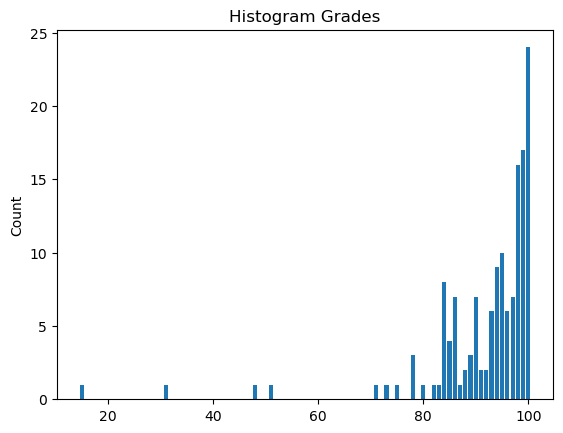

In [30]:
# Let's check grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()

#### Merging scores with features

In [31]:
from joblib import dump

temp_df = pd.merge(merged_df, scores, on='code', how="left")
temp_df.dropna(inplace=True)
temp_df.drop_duplicates("code",inplace=True, keep="first")

temp_df = temp_df[temp_df['grade'] >= 70]

temp_df['grade'] = temp_df['grade'] - 70

scaler = StandardScaler()

temp_df['grade'] = scaler.fit_transform(temp_df[['grade']])
dump(scaler, 'scaler.joblib')
temp_df.head()


,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,...,modified_count_0,modified_count_1,modified_count_2,modified_count_3,modified_count_4,modified_count_5,modified_count_6,modified_count_7,modified_count_8,grade
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.192013,0.795607,0.772184,0.882656,0.607114,0.987511,0.892586,0.570741,0.543866,...,0.0,0.05,0.75,0.05,0.4,0.4,0.15,0.3,0.1,0.816992
2,041f950b-c013-409a-a642-cffff60b9d4b,0.258306,0.295923,0.624824,0.351872,0.643038,0.454314,0.540269,0.546506,0.325793,...,0.0,0.00,0.30,0.15,0.1,0.0,0.30,0.1,0.0,-0.553696
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.145965,0.117841,0.267346,0.316809,0.333889,0.309084,0.192434,0.261892,0.407106,...,0.0,0.00,0.90,0.15,0.6,0.2,0.15,0.2,0.1,0.512395
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.344182,0.575528,0.782883,0.624833,0.724872,0.872171,0.684797,0.945305,0.511769,...,0.5,0.05,2.85,0.75,1.7,1.8,1.05,0.4,0.9,0.969291
5,090d6217-5d69-4929-a342-19abab78324f,0.181981,0.716248,0.654161,0.710065,0.678797,0.872171,0.794699,0.652518,0.810325,...,0.0,0.25,2.25,0.65,1.0,1.4,0.90,0.5,1.2,-1.467488


In [32]:
X = temp_df[temp_df.columns[1:-1]].to_numpy()
y = temp_df["grade"].to_numpy()
print(X.shape, y.shape)

(118, 468) (118,)


#### Train/Test split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

Train set size: 94
Test set size: 24


#### Fitting a model

#### Predicting and Analyzing 

In [34]:
from joblib import dump

regressor = DecisionTreeRegressor(random_state=0,criterion='squared_error', max_depth=5)
regressor.fit(X_train, y_train)

dump(regressor, '412_model.joblib')

['412_model.joblib']

In [35]:
extracted_MSEs = regressor.tree_.impurity   
for idx, MSE in enumerate(regressor.tree_.impurity):
    print("Node {} has MSE {}".format(idx,MSE))

Node 0 has MSE 0.9058181813259566
Node 1 has MSE 1.2586574827217656
Node 2 has MSE 1.3932309919328423
Node 3 has MSE 0.5860256410474337
Node 4 has MSE 0.005798718984516116
Node 5 has MSE 0.0
Node 6 has MSE -1.1102230246251565e-16
Node 7 has MSE 0.11504658465280149
Node 8 has MSE 0.0
Node 9 has MSE 0.015946477207419762
Node 10 has MSE 0.939155793084093
Node 11 has MSE 0.2996004808666708
Node 12 has MSE 0.08553110502161232
Node 13 has MSE 0.023194875938067128
Node 14 has MSE 1.984089975648473e-15
Node 15 has MSE 0.6452159118283847
Node 16 has MSE 0.44323958237895744
Node 17 has MSE 0.10824275437763592
Node 18 has MSE 0.0057987189845162546
Node 19 has MSE -2.220446049250313e-16
Node 20 has MSE 0.3121014667642568
Node 21 has MSE 0.07731625312688267
Node 22 has MSE 0.32472826313290726
Node 23 has MSE 0.036080918125879435
Node 24 has MSE 0.005798718984516116
Node 25 has MSE 0.0
Node 26 has MSE -4.440892098500626e-16
Node 27 has MSE -4.440892098500626e-16
Node 28 has MSE 0.43532312711924115
N

In [36]:
# Prediction
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test,y_test_pred))

print("R2 Train:", r2_score(y_train,y_train_pred))
print("R2 TEST:", r2_score(y_test,y_test_pred))


MSE Train: 0.12114147881199924
MSE TEST: 2.0223849512949665
R2 Train: 0.8662629197454729
R2 TEST: -0.510209863091617


In [37]:
from sklearn.linear_model import Lasso

lasso_regressor = Lasso(alpha=0.01, random_state=0)  
lasso_regressor.fit(X_train, y_train)

y_train_pred_lasso = lasso_regressor.predict(X_train)
y_test_pred_lasso = lasso_regressor.predict(X_test)

print("\nLasso Regression:")
print("MSE Train:", mean_squared_error(y_train, y_train_pred_lasso))
print("MSE Test:", mean_squared_error(y_test, y_test_pred_lasso))
print("R2 Train:", r2_score(y_train, y_train_pred_lasso))
print("R2 Test:", r2_score(y_test, y_test_pred_lasso))



Lasso Regression:
MSE Train: 0.6189626326236026
MSE Test: 1.9058543100748302
R2 Train: 0.31668115590531454
R2 Test: -0.42319095820392305


In [38]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

pca = PCA(n_components=0.95)  # Keep 95% of variance
linear_reg = LinearRegression()
pcr = make_pipeline(pca, linear_reg)

pcr.fit(X_train, y_train)

y_train_pred_pcr = pcr.predict(X_train)
y_test_pred_pcr = pcr.predict(X_test)

print("\nPrincipal Component Regression:")
print("MSE Train:", mean_squared_error(y_train, y_train_pred_pcr))
print("MSE Test:", mean_squared_error(y_test, y_test_pred_pcr))
print("R2 Train:", r2_score(y_train, y_train_pred_pcr))
print("R2 Test:", r2_score(y_test, y_test_pred_pcr))



Principal Component Regression:
MSE Train: 0.7723967766238681
MSE Test: 1.6259881278969317
R2 Train: 0.1472938029426425
R2 Test: -0.21420173070783055


In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

random_forest_regressor = RandomForestRegressor(random_state=42, n_estimators=40)  # n_estimators can be adjusted

random_forest_regressor.fit(X_train, y_train)
dump(random_forest_regressor, '412_rf_model.joblib')

y_train_pred_rf = random_forest_regressor.predict(X_train)
y_test_pred_rf = random_forest_regressor.predict(X_test)

print("Random Forest Regressor:")
print("MSE Train:", mean_squared_error(y_train, y_train_pred_rf))
print("MSE Test:", mean_squared_error(y_test, y_test_pred_rf))

print("R2 Train:", r2_score(y_train, y_train_pred_rf))
print("R2 Test:", r2_score(y_test, y_test_pred_rf))


Random Forest Regressor:
MSE Train: 0.1284448641532753
MSE Test: 1.427212730230189
R2 Train: 0.8582001699664993
R2 Test: -0.06576680198466378


In [40]:
"""
In this cell, almost all combinations have been tried.
PCA+RF, RF+Lasso, Lasso+RF, RF + Average, PCR + Average and etc.
"""

X_train_ensemble = np.column_stack((y_train_pred_rf, y_train_pred_lasso)) 
X_test_ensemble = np.column_stack((y_test_pred_rf, y_test_pred_lasso))

ensemble_regressor = DecisionTreeRegressor(random_state=42)
ensemble_regressor.fit(X_train_ensemble, y_train)

y_train_pred_ensemble = ensemble_regressor.predict(X_train_ensemble)
y_test_pred_ensemble = ensemble_regressor.predict(X_test_ensemble)

print("Ensemble Model with Decision Tree Regressor:")
print("MSE Train:", mean_squared_error(y_train, y_train_pred_ensemble))
print("MSE Test:", mean_squared_error(y_test, y_test_pred_ensemble))
print("R2 Train:", r2_score(y_train, y_train_pred_ensemble))
print("R2 Test:", r2_score(y_test, y_test_pred_ensemble))

Ensemble Model with Decision Tree Regressor:
MSE Train: 1.5981120815128126e-33
MSE Test: 1.524096639763676
R2 Train: 1.0
R2 Test: -0.13811456923770837
